In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
pd.options.mode.chained_assignment = None

# Tracking Data

   - Data about in-game actions and trajectories. 
   <br>
   <br>
   - Most tracking data is collected by utilizing machine vision to gather precise spatio-temporal information.
   <br>
   <br>
   - Can be independent from the sport itself.

### Events and Trajectories

- Often adopting a third-person perspective on the data
   <br>
   <br>
   - **Types of Visualization:**
       - Event density map.
       - Events representation.
       - Trajectories.
       - Detailed events with context.
       - Real-time.
       
       <div style="text-align:center"><img width="1200px" src="./images/basketball_shot_distribution_density.png"/></div>
       <br>
       <br>
       <div style="text-align:center">Figure 1: Shot distribution and density in CourtVision (Goldsberry K., 2012).</div>

### Players’ point of view

   - Often adopting a first-person perspective on the data
   <br>
   <br>
   - **Types of Visualization:**
       - First-person.
       - Embedded tracking and visualization.
       
       
<div style="text-align:center"><img width="500px" src="./images/penalty_shooter_point_of_view.png"/></div>
<br>
<br>
<div style="text-align:center">Figure 2: A penalty shooter’s point of view is reconstructed in 3D, showing her favorite target areas around the goalkeeper (Rusu A., Stoica D., Burns E.).</div>

# Detailed NFL Play-by-Play Data (2009-2017)

## Load Data

Dataset: https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016

Source: https://www.kaggle.com/carrie1/nfl-te-qb-duo-performance

In [2]:
df = pd.read_csv('../datasets/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv')
df.head(5)

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


## Clean & Preprocessing Data

In [3]:
columns = ["Date", "posteam", "desc", "PassAttempt", "ydsnet", "sp"]
df = df[columns]
df.head(10)

,Date,posteam,desc,PassAttempt,ydsnet,sp
0,2009-09-10,PIT,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,0,0,0
1,2009-09-10,PIT,(14:53) B.Roethlisberger pass short left to H....,1,5,0
2,2009-09-10,PIT,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,2,0
3,2009-09-10,PIT,(13:35) (Shotgun) B.Roethlisberger pass incomp...,1,2,0
4,2009-09-10,PIT,(13:27) (Punt formation) D.Sepulveda punts 54 ...,0,2,0
5,2009-09-10,TEN,(13:16) C.Johnson up the middle to TEN 2 for n...,0,0,0
6,2009-09-10,TEN,(12:40) K.Collins pass short left to A.Hall to...,1,4,0
7,2009-09-10,TEN,(12:11) (Shotgun) C.Johnson left end to TEN 4 ...,0,2,0
8,2009-09-10,TEN,(11:34) (Punt formation) C.Hentrich punts 50 y...,0,2,0
9,2009-09-10,PIT,(11:24) B.Roethlisberger pass short right to M...,1,3,0


In [4]:
def _find_QB_and_TE_plays(df2, posteam, qb, te):
    new_df = df[(df["posteam"] == posteam)  & (df["desc"].str.contains(qb)) &
        (df["desc"].str.contains(te)) & (df['PassAttempt'] == 1)]
    new_df['duo'] = '%s & %s' % (qb, te)
    return df2.append(new_df)

In [5]:
posteams = ['DAL', 'NE', 'TEN', 'CIN', 'CAR', 'SD', 'NO', 'SEA', 'PHI', 'DET', 'JAC', 'KC']
qbs = ['T.Romo', 'T.Brady', 'M.Mariota', 'A.Dalton', 'C.Newton', 'P.Rivers', 'D.Brees', 
       'R.Wilson', 'S.Bradford', 'M.Stafford', 'B.Bortles', 'A.Smith']
tes = ['J.Witten', 'R.Gronkowski',  'D.Walker', 'T.Eifert', 'G.Olsen', 'A.Gates', 'J.Graham', 
        'J.Graham', 'Z.Ertz', 'E.Ebron', 'J.Thomas', 'T.Kelce']

In [6]:
df2 = pd.DataFrame()

for posteam, qb, te in zip(posteams, qbs, tes):
    df2 = _find_QB_and_TE_plays(df2, posteam, qb, te)
    
df2.head()

,Date,posteam,desc,PassAttempt,ydsnet,sp,duo
556,2009-09-13,DAL,(3:18) T.Romo pass short left to J.Witten push...,1,40,0,T.Romo & J.Witten
588,2009-09-13,DAL,(5:47) (Shotgun) T.Romo pass incomplete deep l...,1,3,0,T.Romo & J.Witten
593,2009-09-13,DAL,(4:20) (Shotgun) T.Romo pass short middle to J...,1,35,0,T.Romo & J.Witten
605,2009-09-13,DAL,(1:02) (Shotgun) T.Romo pass short right to J....,1,9,0,T.Romo & J.Witten
642,2009-09-13,DAL,(4:38) T.Romo pass short right to J.Witten pus...,1,26,0,T.Romo & J.Witten


## Data statistics

In [7]:
df2["duo"].value_counts()

P.Rivers & A.Gates        803
T.Brady & R.Gronkowski    791
C.Newton & G.Olsen        725
T.Romo & J.Witten         643
D.Brees & J.Graham        622
A.Smith & T.Kelce         427
M.Stafford & E.Ebron      304
M.Mariota & D.Walker      297
R.Wilson & J.Graham       278
A.Dalton & T.Eifert       201
S.Bradford & Z.Ertz       115
B.Bortles & J.Thomas       96
Name: duo, dtype: int64

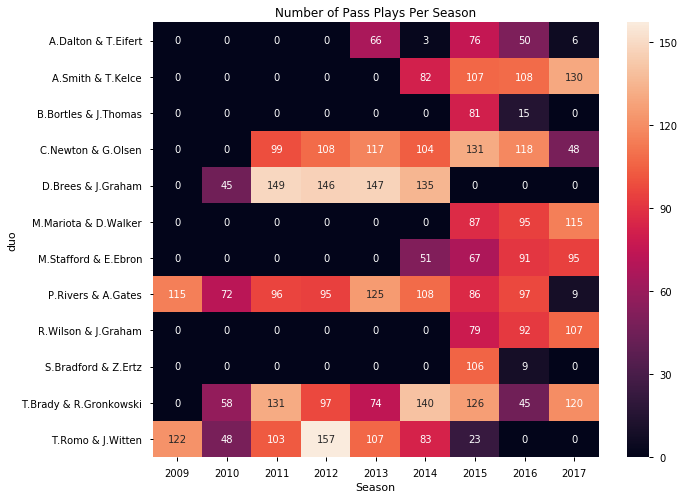

In [8]:
df2['Season'] = df2['Date'].str[:4]
ct = pd.crosstab(df2['duo'], df2['Season'])
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ct, annot=True, fmt="d").set_title('Number of Pass Plays Per Season')

## Net Yards per Play between QB and TE

**Net Yards:** This statistic is calculated by subtracting a team's starting position on the field from the team's ending field position

**Swarm Plot:** Draw a categorical scatterplot with non-overlapping points. 

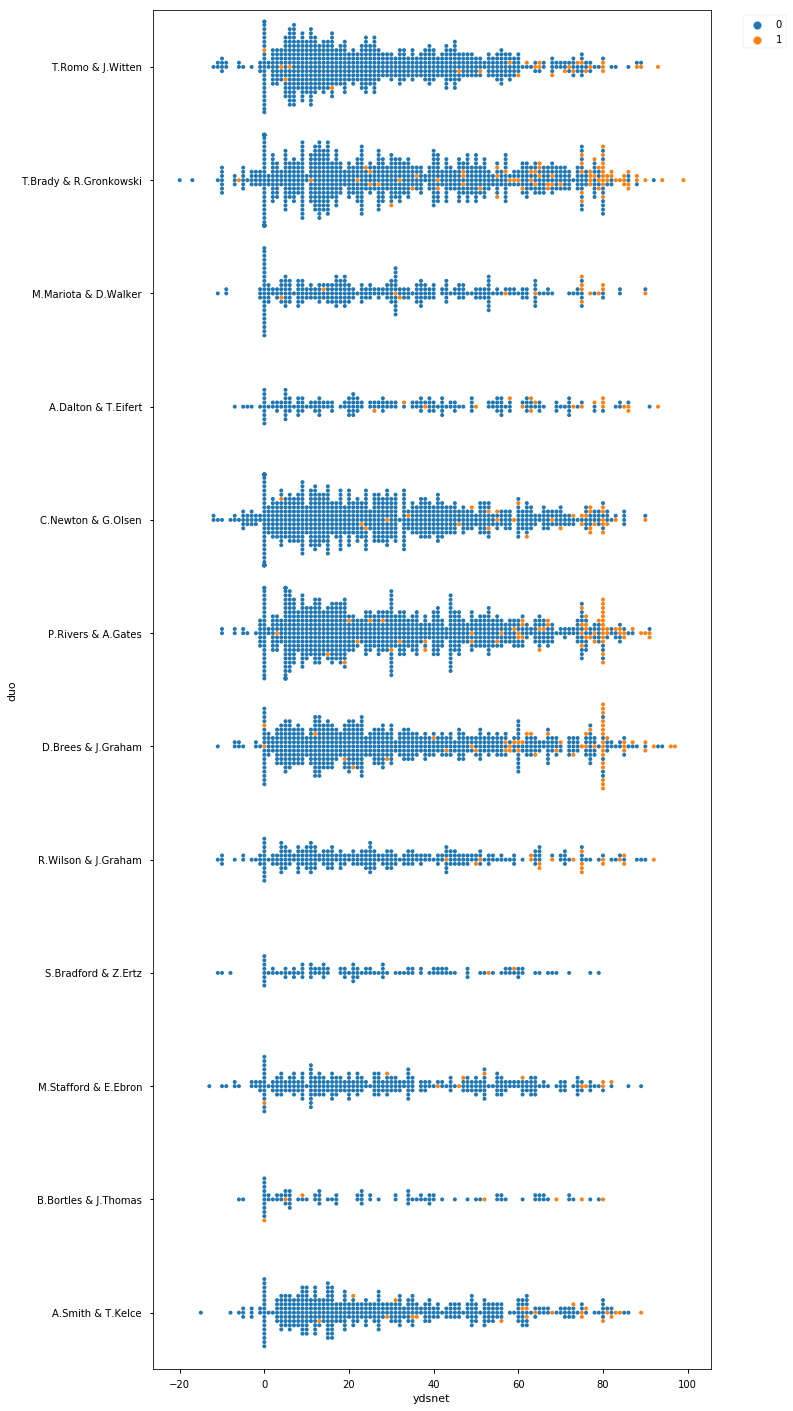

In [9]:
plt.figure(figsize=(10, 25))
ax = sns.swarmplot(x="ydsnet", y="duo", hue="sp", data=df2, size=4)
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Done!